<a href="https://colab.research.google.com/github/ChunkaiFu/CSCE636/blob/main/CSCE636HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Downloading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp '/content/drive/MyDrive/Kaggle/kaggle.json' '/content'

In [ ]:
import zipfile
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
!kaggle datasets download -d biaiscience/dogs-vs-cats

100% 814M/817M [00:07<00:00, 123MB/s]
100% 817M/817M [00:07<00:00, 109MB/s]


In [ ]:
!unzip -qq dogs-vs-cats.zip

**Copying images to training, validation, and test directories**

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train/train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [5]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [ ]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [ ]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [3]:
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Displaying some randomly augmented training images**

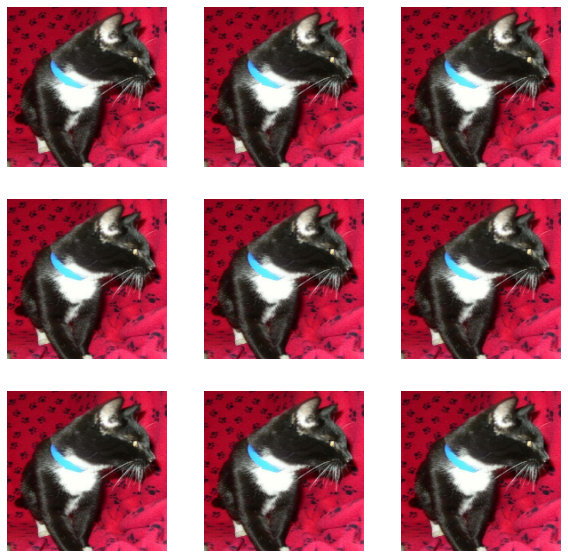

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Feature extraction with a pretrained model

**Instantiating the Xception convolutional base**

In [6]:
conv_base = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(180, 180, 3),
    pooling=None,
    classes=2,
    classifier_activation="softmax",
)

83697664/83683744 [==============================] - 0s 0us/step


In [7]:
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 89, 89, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 89, 89, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

#### Fast feature extraction without data augmentation

**Extracting the Xception features and corresponding labels**

if the include_top is false, it means that the preprocessed data will go through the Xception conv_base and then go through our customized denser layers. Why do we need the get_features_and_labels function? 

In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = tf.keras.applications.xception.preprocess_input(images, data_format=None)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

In [ ]:
train_features.shape

(2000, 6, 6, 2048)

**Defining and training the densely connected classifier**

In [ ]:
inputs = keras.Input(shape=(6, 6, 2048))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
opt = keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(loss="binary_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 16s 242ms/step - loss: 0.3067 - accuracy: 0.9610 - val_loss: 0.2384 - val_accuracy: 0.9780
Epoch 2/20
63/63 [==============================] - 15s 234ms/step - loss: 0.2137 - accuracy: 0.9785 - val_loss: 0.2452 - val_accuracy: 0.9820
Epoch 3/20
63/63 [==============================] - 15s 235ms/step - loss: 0.1029 - accuracy: 0.9875 - val_loss: 0.2823 - val_accuracy: 0.9830
Epoch 4/20
63/63 [==============================] - 15s 232ms/step - loss: 0.1155 - accuracy: 0.9905 - val_loss: 0.2578 - val_accuracy: 0.9840
Epoch 5/20
63/63 [==============================] - 14s 229ms/step - loss: 0.0416 - accuracy: 0.9925 - val_loss: 0.4144 - val_accuracy: 0.9770
Epoch 6/20
63/63 [==============================] - 14s 229ms/step - loss: 0.0483 - accuracy: 0.9940 - val_loss: 0.2512 - val_accuracy: 0.9870
Epoch 7/20
63/63 [==============================] - 15s 232ms/step - loss: 0.0280 - accuracy: 0.9965 - val_loss: 0.2971 - val_accuracy: 0.9810

**Plotting the results**

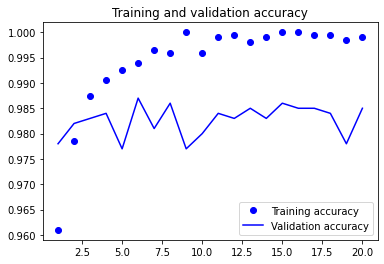

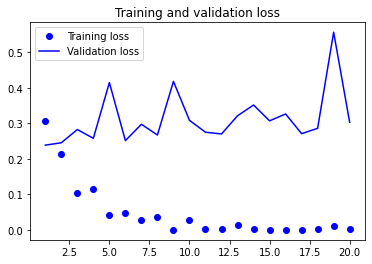

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_metrics = model.evaluate(test_features, test_labels, return_dict=True)

63/63 [==============================] - 3s 40ms/step - loss: 0.3230 - accuracy: 0.9840


In [ ]:
test_metrics

{'accuracy': 0.984000027179718, 'loss': 0.3229597806930542}

#### Feature extraction with data augmentation

**Instantiating and freezing the Xception convolutional base**

In [ ]:
conv_base = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(180, 180, 3),
    pooling=None,
    classes=2,
    classifier_activation="softmax",
)
conv_base.trainable = False

**Printing the list of trainable weights before and after freezing**

In [ ]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 154


In [ ]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


**Adding a data augmentation stage and a classifier to the convolutional base**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.xception.preprocess_input(x, data_format=None)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
opt = keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(loss="binary_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

the data is enhanced with variety, but the actual fit function still uses the original dataset for training. But how the augmented data played a role in the model/training?

The traning of extraction with data augmentation takes a long time, over 2 hours. 

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 359s 6s/step - loss: 0.8882 - accuracy: 0.9245 - val_loss: 0.2282 - val_accuracy: 0.9770
Epoch 2/20
63/63 [==============================] - 352s 6s/step - loss: 0.5768 - accuracy: 0.9535 - val_loss: 0.3069 - val_accuracy: 0.9760
Epoch 3/20
63/63 [==============================] - 348s 6s/step - loss: 0.4618 - accuracy: 0.9655 - val_loss: 0.1911 - val_accuracy: 0.9820
Epoch 4/20
63/63 [==============================] - 346s 6s/step - loss: 0.6376 - accuracy: 0.9600 - val_loss: 0.2308 - val_accuracy: 0.9840
Epoch 5/20
63/63 [==============================] - 345s 5s/step - loss: 0.4100 - accuracy: 0.9675 - val_loss: 0.2008 - val_accuracy: 0.9850
Epoch 6/20
63/63 [==============================] - 344s 5s/step - loss: 0.3944 - accuracy: 0.9665 - val_loss: 0.2830 - val_accuracy: 0.9790
Epoch 7/20
63/63 [==============================] - 341s 5s/step - loss: 0.4992 - accuracy: 0.9670 - val_loss: 0.2314 - val_accuracy: 0.9890
Epoch 8/20
63

**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 222s 4s/step - loss: 0.2212 - accuracy: 0.9820
Test accuracy: 0.982


### Fine-tuning a pretrained model

In [ ]:
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 89, 89, 32)   864         ['input_7[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 89, 89, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

**Freezing all layers until the fourth from the last**

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Fine-tuning the model**

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 397s 6s/step - loss: 0.1283 - accuracy: 0.9855 - val_loss: 0.2338 - val_accuracy: 0.9820
Epoch 2/20
63/63 [==============================] - 388s 6s/step - loss: 0.1950 - accuracy: 0.9775 - val_loss: 0.2289 - val_accuracy: 0.9810
Epoch 3/20
63/63 [==============================] - 388s 6s/step - loss: 0.1524 - accuracy: 0.9845 - val_loss: 0.2239 - val_accuracy: 0.9820
Epoch 4/20
63/63 [==============================] - 388s 6s/step - loss: 0.2066 - accuracy: 0.9800 - val_loss: 0.2084 - val_accuracy: 0.9820
Epoch 5/20
63/63 [==============================] - 385s 6s/step - loss: 0.1209 - accuracy: 0.9860 - val_loss: 0.2123 - val_accuracy: 0.9840
Epoch 6/20
63/63 [==============================] - 384s 6s/step - loss: 0.1463 - accuracy: 0.9855 - val_loss: 0.2000 - val_accuracy: 0.9870
Epoch 7/20
63/63 [==============================] - 384s 6s/step - loss: 0.1436 - accuracy: 0.9830 - val_loss: 0.1995 - val_accuracy: 0.9830
Epoch 8/20
63

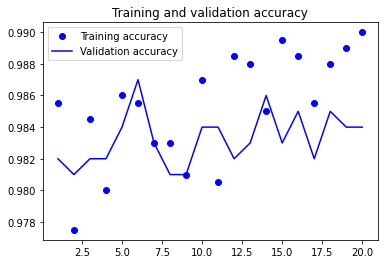

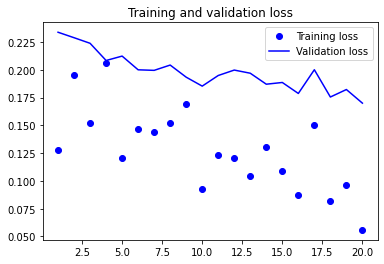

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 219s 3s/step - loss: 0.2188 - accuracy: 0.9810
Test accuracy: 0.981


## Summary

Feature extraction wihout data augmentation: define the conv_base and use predict() function to get the features tensor. The features tensor is then fed into a top layer (i.e., dense layer, classifier layer) to complete the whole model. The model input is the features tensor and output is a probability (one neuron at last layer, since is a binary classification.) 

Different pretrained models usually require some preprocessing. 

Feature extraction with data augmentation: define the conv_base, and use it as the first big layer of the new model, then flatten and add dense layers etc. The model input is a 3 channel image and output is a probability (one neuron). 

What is the difference between using the conv_base and using the get_features_and labels function? Both of them seem to be used on the preprocessed data and then followed by dense and dropout layers. 

The augmented data is used in the model definition, but the model training still uses the original data. Then what is the exact role the augmented data is playing if it is not involved in training but only in model definition? 

The Xception apeared tp be a good model with high accuracy. The training also yielded overall decreasing loss and increasing accuracy over the epochs. 




